# Gerando um grafo não-orientado a partir da imagem de um mapa

#### Carlos Eduardo Cassimiro da Silva
#### Francisco David

Uma das visualizações que pretendemos fazer no trabalho final da disciplina é de uma rede os municípios apontam para o seu vizinho com maior número de cvli. Para isso, precisamos construir um grafo não-orientado entre os municípios. Na primeira tentativa feita utilizei Triangulação de Delaunay, mas a triangulação ligava muito pontos além do real no mapa. Para solucionar esse problema, pensei em utilizar o algoritmo da Coloração em 4 Cores de um Mapa. Buscando pelo algoritmo encontrei uma solução baseada em processamento digital de imagensm, onde o script já cria um nó não estruturado dos vizinhos.

Link do script original: https://github.com/Erfaniaa/map-coloring <br>
Link do dataset: https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-23-mun.json

Sumário
Módulos utilizados <br>
1. Script original <br>
2. Adaptação <br>
3. Agregando os nomes <br>

##### Módulos utilizados

In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
import json

# 1. Script original

In [2]:
ESCAPE_KEY_CHARACTER = 27
NO_COLOR = -1
NOT_MARKED = -1
BACKGROUND_MARK = -2
SLEEP_TIME_IN_MILLISECONDS = 100
MINIMUM_BORDER_WIDTH_RATIO = 0.15
IMPORTANT_COLOR_HIGH_THRESHOLD = 256 - 35
IMPORTANT_COLOR_LOW_THRESHOLD = 35
MINIMUM_REGION_AREA_RATIO = 0.0005
MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE = 50
INF = 10 ** 30
MAXIMUM_NUMBER_OF_REGIONS = 1000
COLORING_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
DX = [-1, +1, 0, 0]
DY = [0, 0, -1, +1]
SHARPEN_KERNEL = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

image = cv2.imread('arquivos/mapa/ceara3.png', cv2.IMREAD_COLOR)
height = len(image)
width = len(image[0])

total_area = width * height
mark = [[NOT_MARKED for i in range(width)] for j in range(height)]
nodes = []
regions = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)]
regions_border = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)]
nodes_color = [NO_COLOR for i in range(MAXIMUM_NUMBER_OF_REGIONS)]

class Node:
    def __init__(self, node_id, node_x, node_y):
        self.id = node_id
        self.x = node_x
        self.y = node_y
        self.adj = []
    def add_edge(self, node):
        self.adj.append(node.id)

def apply_threshold():
    for y in range(height):
        for x in range(width):
            b, g, r = image[y][x]
            r, g, b = int(r), int(g), int(b)
            if r + g + b < IMPORTANT_COLOR_LOW_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK
            if r + g + b > IMPORTANT_COLOR_HIGH_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK

def whiten_background():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED or mark[y][x] == BACKGROUND_MARK:
                image[y][x] = (255, 255, 255)

def get_all_regions_pixels():
    for y in range(height):
        for x in range(width):
            region_mark = mark[y][x]
            regions[region_mark].append((x, y))
            if is_on_border(x, y):
                regions_border[region_mark].append((x, y))

def find_graph_nodes():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED:
                color_area = get_region_area(x, y, NOT_MARKED, len(nodes))
                if color_area > MINIMUM_REGION_AREA_RATIO * total_area:
                    nodes.append(Node(len(nodes), x, y))
                else:
                    get_region_area(x, y, len(nodes), NOT_MARKED)
    get_all_regions_pixels()

def is_inside(x, y):
    if x < 0 or x >= width or y < 0 or y >= height:
        return False
    return True

def is_on_border(x, y):
    if mark[y][x] == BACKGROUND_MARK:
        return False
    for k in range(4):
        x2 = x + DX[k]
        y2 = y + DY[k]
        if is_inside(x2, y2) and mark[y2][x2] == BACKGROUND_MARK:
            return True
    return False

def same_pixel_colors(x1, y1, x2, y2):
    if not is_inside(x1, y1) or not is_inside(x2, y2):
        return False
    b1, g1, r1 = image[y1][x1]
    b2, g2, r2 = image[y2][x2]
    r1, g1, b1 = int(r1), int(g1), int(b1)
    r2, g2, b2 = int(r2), int(g2), int(b2)
    diff = abs(r1 - r2) + abs(g1 - g2) + abs(b1 - b2)
    return diff <= 3 * MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE

def get_region_area(start_x, start_y, src_mark, dst_mark):
    if not is_inside(start_x, start_y) or mark[start_y][start_x] != src_mark:
        return 0
    color_area = 0
    queue = [(start_x, start_y)]
    mark[start_y][start_x] = dst_mark
    while queue:
        x, y = queue.pop(0)
        mark[y][x] = dst_mark
        color_area += 1
        for k in range(4):
            x2 = x + DX[k]
            y2 = y + DY[k]
            if is_inside(x2, y2) and mark[y2][x2] == src_mark and same_pixel_colors(x, y, x2, y2):
                mark[y2][x2] = dst_mark
                queue.append((x2, y2))
    return color_area

def are_adjacent(node1:Node, node2:Node):
    start_x, start_y = node1.x, node1.y
    end_x, end_y = node2.x, node2.y
    min_distance_sqr = INF
    for u in regions_border[mark[start_y][start_x]]:
        for v in regions_border[mark[end_y][end_x]]:
            tmp_distance_sqr = (u[0] - v[0]) * (u[0] - v[0]) + (u[1] - v[1]) * (u[1] - v[1])
            if tmp_distance_sqr < min_distance_sqr:
                min_distance_sqr = tmp_distance_sqr
                start_x, start_y = u[0], u[1] 
                end_x, end_y = v[0], v[1] 
    dx, dy = end_x - start_x, end_y - start_y
    if abs(dx) + abs(dy) <= 1:
        return True
    dx, dy = float(dx), float(dy)
    border_width_threshold = MINIMUM_BORDER_WIDTH_RATIO * (width * width + height * height)
    if min_distance_sqr >= border_width_threshold:
        return False
    total_steps = int(2 * ((width * width + height * height) ** 0.5))
    for i in range(total_steps):
        x = int(start_x + i * dx / total_steps + 0.5)
        y = int(start_y + i * dy / total_steps + 0.5)
        if mark[y][x] >= 0 and (x != start_x or y != start_y) and (x != end_x or y != end_y):
            return False
    return True

def add_graph_edges():
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if j > i and are_adjacent(nodes[i], nodes[j]):
                nodes[i].add_edge(nodes[j])
                nodes[j].add_edge(nodes[i])

def change_region_color(node:Node, pixel_color):
    region_idx = mark[node.y][node.x]
    for i in range(len(regions[region_idx])):
        x = regions[region_idx][i][0]
        y = regions[region_idx][i][1]
        image[y][x] = pixel_color

def colorize_map(node_index):
    if node_index == len(nodes):
        for i in range(len(nodes)):
            change_region_color(nodes[i], COLORING_COLORS[nodes_color[i]])
        cv2.imshow('Colorized Map', image)
        key = cv2.waitKey(SLEEP_TIME_IN_MILLISECONDS)
        if key == ESCAPE_KEY_CHARACTER:
            cv2.destroyAllWindows()
            exit()
        return
    for i in range(len(COLORING_COLORS)):
        is_color_valid = True
        for u in nodes[node_index].adj:
            if nodes_color[u] == i:
                is_color_valid = False
                break
        if is_color_valid:
            nodes_color[node_index] = i
            colorize_map(node_index + 1)
            nodes_color[node_index] = NO_COLOR

In [3]:
apply_threshold()
image = cv2.medianBlur(image, 3)
apply_threshold()
image = cv2.filter2D(image, -1, SHARPEN_KERNEL)
apply_threshold()

find_graph_nodes()
add_graph_edges()

whiten_background()

O arquivo de imagem foi alterado e retirei o último passo de calcular e aplicar as cores, já que o objetivo é obter os grafos.

# 2. Adaptação

Apesar do script poupar muito trabalho criando o grafo, ainda precisamos nomear manualmente cada municipio a partir do id que o script gera. Para facilitar essa tarefa, iremos plotar o id no próprio mapa a partir das suas coordenadas.

In [4]:
# Listas para pegar os ids e as coordenadas dos nós 
x_list = []
y_list = []
id_list = []
for i in nodes:
    x_list.append(i.x)
    y_list.append(i.y)
    id_list.append(i.id)

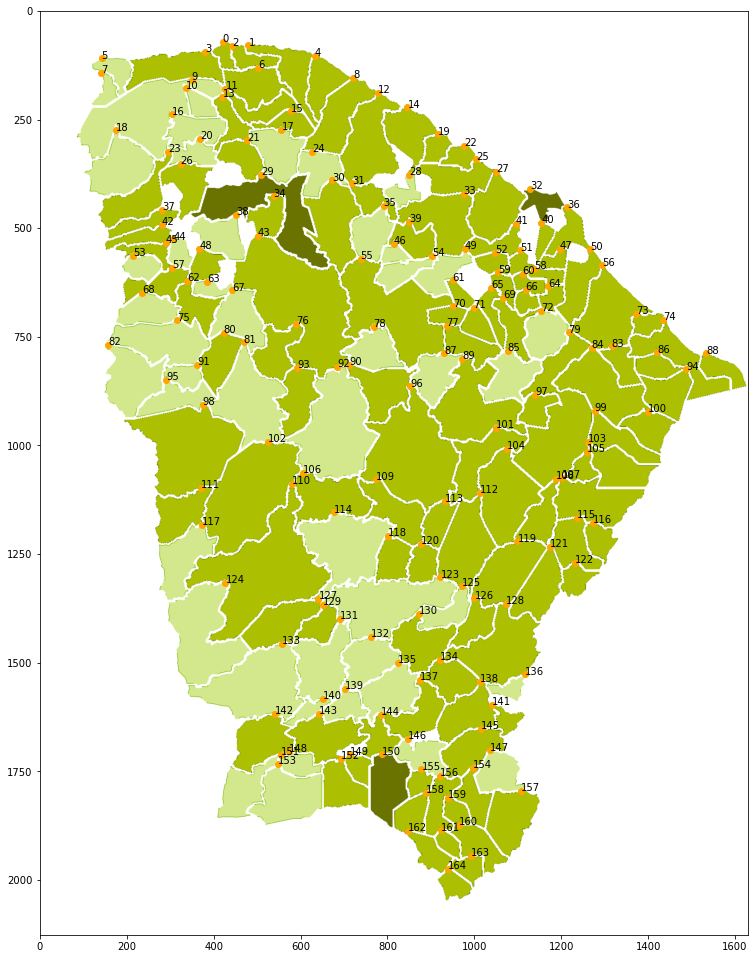

In [9]:
fig, ax = plt.subplots(figsize=(20,17))
ax.scatter(x_list, y_list, c='orange')
for i, txt in enumerate(id_list):
    ax.annotate(txt, (x_list[i], y_list[i]))

ax.imshow(image);

In [10]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

change_region_color(nodes[1], COLORING_COLORS[nodes_color[1]])

# 3. Agregando os nomes

Lista de nomes feita manualmente na ordem dos ids para poder colocar os nomes nos vizinhos também.

In [6]:
nomes = ['JIJOCA DE JERICOACOARA',
'ACARAU',
'CRUZ',
'CAMOCIM',
'ITAREMA',
'BARROQUINHA',
'BELA CRUZ',
'CHAVAL',
'AMONTADA',
'GRANJA',
'MARTINOPOLE',
'MARCO',
'ITAPIPOCA',
'SENADOR SA',
'TRAIRI',
'MORRINHOS',
'URUOCA',
'SANTANA DO ACARAU',
'VIÇOSA DO CEARÁ',
'PARAIPABA',
'MORAUJO',
'MASSAPE',
'PARACURU',
'TIANGUA',
'MIRAIMA',
'SAO GONÇALO DO AMARANTE',
'COREAU',
'CAUCAIA',
'UMIRIM',
'SOBRAL',
'IRAUÇUBA',
'ITAPAJE',
'FORTALEZA',
'PENTECOSTE',
'FORQUILHA',
'TEJUÇUOCA',
'AQUIRAZ',
'UBAJARA',
'CARIRE',
'APUIARES',
'ITAITINGA',
'MARANGUAPE',
'IBIAPINA',
'SANTA QUITERIA',
'GRAÇA',
'SAO BENEDITO',
'GENERAL SAMPAIO',
'HORIZONTE',
'RERIUTABA',
'CARIDADE',
'CASCAVEL',
'GUAIUBA',
'PALMACIA',
'CARNAUBAL',
'PARAMOTI',
'CANINDE',
'BEBERIBE',
'GUARACIABA DO NORTE',
'PACAJUS',
'REDENÇÃO',
'ACARAPE',
'MULUNGU',
'IPU',
'PIRES FERREIRA',
'CHOROZINHO',
'BATURITE',
'BARREIRA',
'HIDROLANDIA',
'CROATA',
'ARACOIABA',
'ARATUBA',
'CAPISTRANO',
'OCARA',
'FORTIM',
'ARACATI',
'IPUEIRAS',
'CATUNDA',
'ITAPIUNA',
'ITATIRA',
'MORADA NOVA',
'NOVA RUSSAS',
'TAMBORIL',
'PORANGA',
'PALHANO',
'RUSSAS',
'IBARETAMA',
'ITAIÇABA',
'CHORO',
'ICAPUI',
'QUIXADA',
'MADALENA',
'ARARENDA',
'BOA VIAJEM',
'MONSENHOR TABOSA',
'JAGUARUANA',
'IPAPORANGA',
'QUIXERAMOBIM',
'IBICUITINGA',
'CRATEUS',
'LIMOEIRO DO NORTE',
'QUIXERE',
'BANABUIU',
'INDEPENDENCIA',
'TABULEIRO DO NORTE',
'JAGUARETAMA',
'SAO JOAO DO JAGUARIBE',
'PEDRA BRANCA',
'ALTO SANTO',
'JAGUARIBARA',
'SANADOR POMPEU',
'TAUA',
'NOVO ORIENTE',
'SOLONOPOLE',
'MILHA',
'MOMBAÇA',
'IRACEMA',
'POTIRETAMA',
'QUITERIANOPOLES',
'PIQUET CARNEIRO',
'JAGUARIBE',
'DEPUTADO IRAPUAN PINHEIRO',
'PEREIRO',
'ERERE',
'ACOPIARA',
'PARAMBU',
'QUIXELO',
'OROS',
'ARNEIROZ',
'ICO',
'CATARINA',
'IGUATU',
'SABOEIRO',
'JUCAS',
'AIUABA',
'CEDRO',
'CARIUS',
'UMARI',
'VARZEA ALEGRE',
'LAVRAS DE MANGABEIRA',
'TARRAFAS',
'ANTONINA DO NORTE',
'IPAUMIRIM',
'CAMPOS SALES',
'ASSARE',
'FARIAS BRITO',
'AURORA',
'CARIRIAÇU',
'BARRO',
'POTENGI',
'NOVA OLINDA',
'CRATO',
'SALITRE',
'SANTANA DO CARIRI',
'ARARIPE',
'BARRO',
'JUAZEIRO DO NORTE',
'MISSAO VELHA',
'MAURITI',
'BARBALHA',
'ABAIARA',
'BREJO SANTO',
'PORTEIRAS',
'JARDIM',
'JATI',
'PENAFORTE']

In [4]:
# Exemplo dos vizinhos de um nó
nodes[0].adj

[2, 3, 6]

In [16]:
# Trocando os ids pelos nomes dos municípios
list_nodes = {} # Dicionário para alocar os nomes
for i in range(len(nodes)):
    list_adj = [] # Lista temporária para adicionar os nomes de cada nó
    for y in nodes[i].adj:
        list_adj.append(nomes[y]) # Como os nomes estão na mesma ordem dos ids, podemos acessá-los diretamento pelo id
    list_nodes[nomes[i]] = list_adj

In [17]:
list_nodes

{'JIJOCA DE JERICOACOARA': ['CRUZ', 'CAMOCIM', 'BELA CRUZ'],
 'ACARAU': ['CRUZ', 'ITAREMA', 'BELA CRUZ', 'AMONTADA', 'MARCO', 'MORRINHOS'],
 'CRUZ': ['JIJOCA DE JERICOACOARA', 'ACARAU', 'BELA CRUZ'],
 'CAMOCIM': ['JIJOCA DE JERICOACOARA',
  'BARROQUINHA',
  'BELA CRUZ',
  'GRANJA',
  'MARCO'],
 'ITAREMA': ['ACARAU', 'AMONTADA'],
 'BARROQUINHA': ['CAMOCIM', 'CHAVAL'],
 'BELA CRUZ': ['JIJOCA DE JERICOACOARA', 'ACARAU', 'CRUZ', 'CAMOCIM', 'MARCO'],
 'CHAVAL': ['BARROQUINHA'],
 'AMONTADA': ['ACARAU',
  'ITAREMA',
  'ITAPIPOCA',
  'MORRINHOS',
  'SANTANA DO ACARAU',
  'MIRAIMA'],
 'GRANJA': ['CAMOCIM',
  'MARTINOPOLE',
  'MARCO',
  'URUOCA',
  'VIÇOSA DO CEARÁ',
  'MORAUJO',
  'TIANGUA'],
 'MARTINOPOLE': ['GRANJA', 'SENADOR SA', 'URUOCA'],
 'MARCO': ['ACARAU',
  'CAMOCIM',
  'BELA CRUZ',
  'GRANJA',
  'SENADOR SA',
  'MORRINHOS'],
 'ITAPIPOCA': ['AMONTADA',
  'TRAIRI',
  'MIRAIMA',
  'UMIRIM',
  'IRAUÇUBA',
  'ITAPAJE'],
 'SENADOR SA': ['MARTINOPOLE',
  'MARCO',
  'MORRINHOS',
  'URUOCA',
 

In [19]:
# Salvando no formato json
with open('arquivos/mucinipios.json', 'w') as outfile: # Salvando os dados em formato geoJSON em um arquivo
    json.dump(list_nodes, outfile)